# 实验一 暗通道先验去雾

## 实验环境
* 操作系统：Ubuntu-22.04(WSL)
* Requirements:
    * matplotlib==3.7.2
    * numpy==1.26.0
    * opencv_python==4.8.1.78

## 实验步骤

导入所需库.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

### 1.Get dark channel image

In [2]:
def get_dark_channel(src_img):
    assert src_img.shape[2] == 3, 'The image\'s shape is not correct!'
    min_img = src_img.min(axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    dst_img = cv2.erode(min_img, kernel)
    
    return dst_img

### 2.Estimate the atmospheric light

In [3]:
def get_alt(src_img, dark_img):
    h, w = src_img.shape[:2]
    src_img = src_img.reshape(h * w, 3)
    dark_img = dark_img.flatten()
    num_pixs = int(np.floor(max(h * w / 1000, 1)))
    indices = dark_img.argsort()
    indices = indices[-num_pixs:]
    pixs = src_img[indices, :]
    alt = np.average(pixs, axis=0)

    return alt

### 3.Estimate the transmission

In [4]:
def get_trans(src_img, alt):
    w = 1
    t = 1 - w * get_dark_channel(src_img/alt)

    return t

### 4.Guided filter

In [5]:
def guided_filter(I, P, r, eps):
    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_P = cv2.boxFilter(P, cv2.CV_64F, (r, r))
    mean_IP = cv2.boxFilter(I*P, cv2.CV_64F, (r, r))
    cov_IP = mean_IP - mean_I * mean_P

    mean_II = cv2.boxFilter(I*I, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_IP / (var_I + eps)
    b = mean_P - a*mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    dst = mean_a * I + mean_b

    return dst

### 5.Restore the image

In [6]:
def get_restore(src, alt, t):
    dst = np.empty(src.shape)
    for i in range(3):
        dst[:, :, i] = (src[:, :, i]-alt[i])/cv2.max(t, 0.1)+alt[i]
    return dst

### 6.Experiment results

In [7]:
def plot_results(src,dark,t,dst):
    plt.subplot(221)
    plt.imshow(src[:,:,::-1])
    plt.axis('off')
    plt.title('Haze Image')
    plt.subplot(222)
    plt.imshow(dark,cmap='gray')
    plt.axis('off')
    plt.title('Dark Channel Image')
    plt.subplot(223)
    plt.imshow(t,cmap='gray')
    plt.axis('off')
    plt.title('Estimated Transmission')
    plt.subplot(224)
    plt.imshow(dst[:,:,::-1])
    plt.axis('off')
    plt.title('Dehazed Image')
    plt.figure(figsize=(4,6))
    
    plt.show()

In [8]:
def dehaze(img_path):
    src = cv2.imread(img_path)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    src = src.astype('float64')/255
    gray = gray.astype('float64')/255
    dark = get_dark_channel(src)
    A = get_alt(src, dark)
    t = get_trans(src, A)
    t = guided_filter(gray, t, 60, 0.0001)
    dst = get_restore(src, A, t)
    cv2.imwrite('Dehazed'+img_path,dst*255)
    plot_results(src,dark,t,dst)

## 实验成果

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


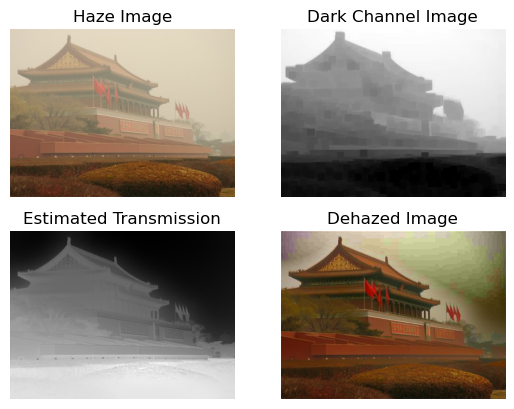

<Figure size 400x600 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


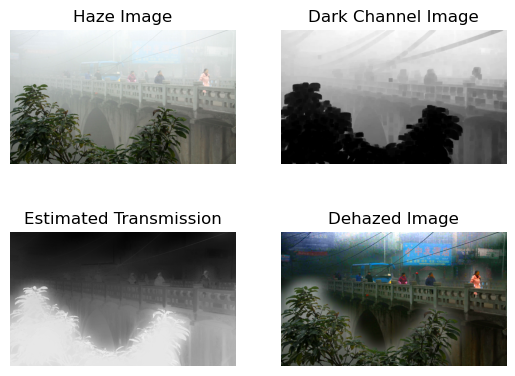

<Figure size 400x600 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


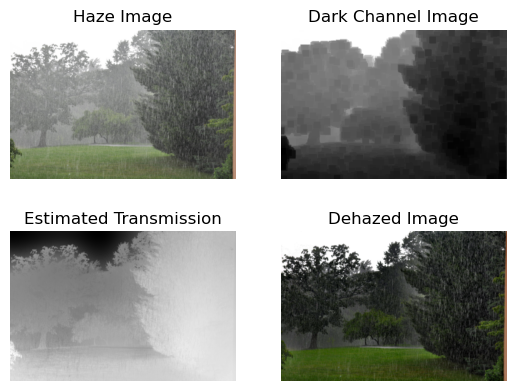

<Figure size 400x600 with 0 Axes>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


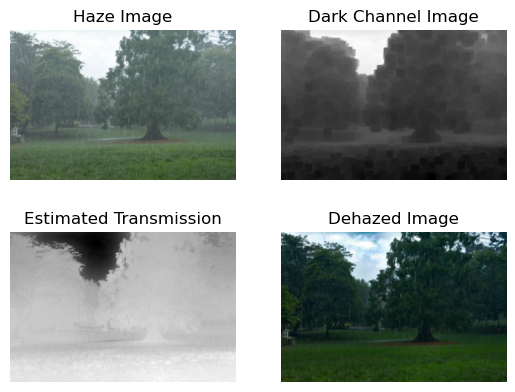

<Figure size 400x600 with 0 Axes>

In [9]:
if __name__ == '__main__':
    image1 = 'foggy1.jpg'
    image2 = 'foggy2.jpg'
    image3 = 'rainy1.png'
    image4 = 'rainy2.png'
    
    dehaze(image1)
    dehaze(image2)
    dehaze(image3)
    dehaze(image4)
    
    

## 结论心得
至此，我们已经成功复现了暗通道先验去雾算法，由输出的结果可以看出，这种算法的去雾能力较为显著，在示例图片上均取得了不错的效果，然而算法本身却非常简洁明了，这提示我们在解决实际问题的时候，要多观察问题的表象以寻求问题的本质，在制定问题的解决方案之前看，做好调研考察工作也许会起到事半功倍的效果。
